In [22]:
library('SGL')
library('grpregOverlap')
library('MASS')
library('glmnet')
library('parallel')

Loading required package: grpreg

Attaching package: ‘MASS’

The following object is masked from ‘package:grpregOverlap’:

    select

The following object is masked from ‘package:grpreg’:

    select

Loading required package: foreach
Loaded glmnet 2.0-16



In [ ]:
df <- read.csv('../data/totalDataDF.csv', header=TRUE)

In [ ]:
binaryPathwayDF <- read.delim('../data/pathways.tsv', header=TRUE)

In [ ]:
rownames(df) <- df$PCG
df = df [ , !(names(df) %in% c('PCG'))]

In [ ]:
binaryPathwayDF$Genes <- unlist(lapply(binaryPathwayDF$Genes, as.character))
rownames(binaryPathwayDF) <- binaryPathwayDF$Genes
binaryPathwayDF = binaryPathwayDF [ , !(names(binaryPathwayDF) %in% c('Genes'))]

In [ ]:
head(binaryPathwayDF)

In [ ]:
dim(binaryPathwayDF)

In [ ]:
tail(df)

In [ ]:
df_genes <- df[row.names(binaryPathwayDF), ]

In [ ]:
df_genes <- df_genes[rowSums(is.na(df_genes)) != ncol(df_genes), ]
binaryPathwayDF <- binaryPathwayDF[row.names(df_genes), ]

In [ ]:
braak_stage <- df['BRAAK', ]
braak_stage <- t(braak_stage)

In [ ]:
df_genes <- t(df_genes)

In [ ]:
for(i in 1:ncol(df_genes)) {
    df_genes[is.na(df_genes[,i]), i] <- mean(df_genes[,i], na.rm = TRUE)
} #Impute missing values with mean of gene value over samples

In [ ]:
path_group_df <- apply(binaryPathwayDF, 2, function(x, bp) { 
    row.names(bp)[which(x == 1)]
}, binaryPathwayDF)

In [ ]:
x <- df_genes[which(!is.na(braak_stage)),]
y <- braak_stage[which(!is.na(braak_stage))]

In [ ]:
cv_fit <- cv.glmnet(x, y, alpha=0.5)

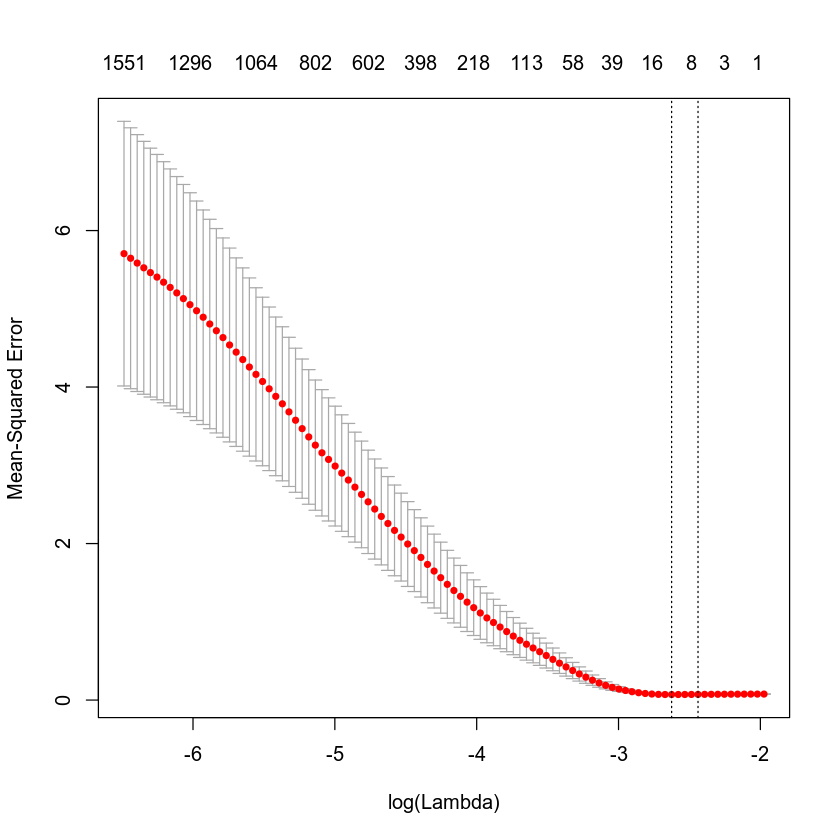

In [40]:
plot(cv_fit)

In [ ]:
cv_fit$cvm[cv_fit$lambda == cv_fit$lambda.min]

In [ ]:
start_time <- Sys.time()
end_time <- Sys.time()
grp_fit <- cv.grpregOverlap(x, y, path_group_df, penalty="grLasso", alpha=0.5)
end_time - start_time

In [ ]:
print(end_time - start_time)

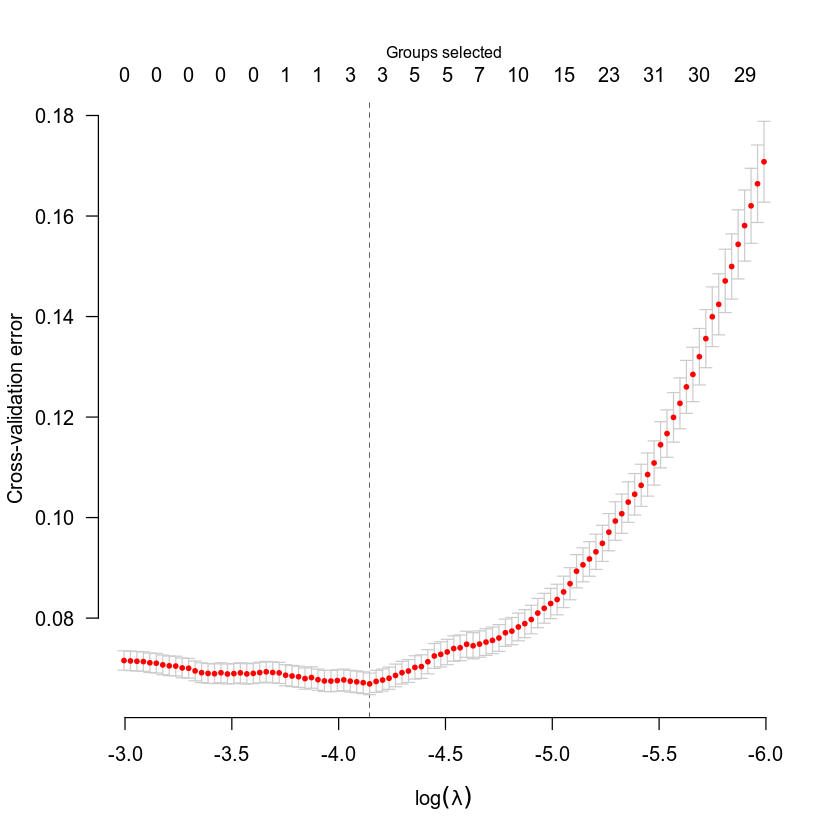

In [27]:
plot(grp_fit)

In [38]:
names(grp_fit)

[1] "cve"        "cvse"       "lambda"     "fit"        "min"       
[6] "lambda.min" "null.dev"

In [39]:
grp_fit$cve[grp_fit$lambda == grp_fit$lambda.min]

[1] 0.06691749

In [ ]:
alphalist <- seq(0,1,by=0.1)
elasticnet <- mclapply(alphalist, function(a){
  cat(sprintf("Started alpha:\t%f, at time %s\n", a, Sys.time()), file="elastic_output.txt", append=TRUE)
  cv_fit_temp <- cv.glmnet(x, y, alpha=a)
  cat(sprintf("Ended alpha:\t%f, at time %s\n", a, Sys.time()), file="elastic_output.txt", append=TRUE)

  cv_fit_temp
}, mc.cores=2)

In [ ]:
elasticnet_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(elasticnet, function(o) {o$lambda.min}))), 
                            'cvm' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvm[o$lambda == o$lambda.min]}))),
                            'cvsd' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvsd[o$lambda == o$lambda.min]}))),
                            'alpha' = alphalist)

In [56]:
ls()

[1] "alphalist"       "best_alpha"      "best_alpha_ovl"  "best_lambda"    
 [5] "best_lambda_ovl" "binaryPathwayDF" "braak_stage"     "cv_fit"         
 [9] "df"              "df_genes"        "elasticnet"      "elasticnet_df"  
[13] "end_time"        "grp_fit"         "i"               "overlap_gl"     
[17] "overlap_gl_df"   "path_group_df"   "start_time"      "x"              
[21] "y"

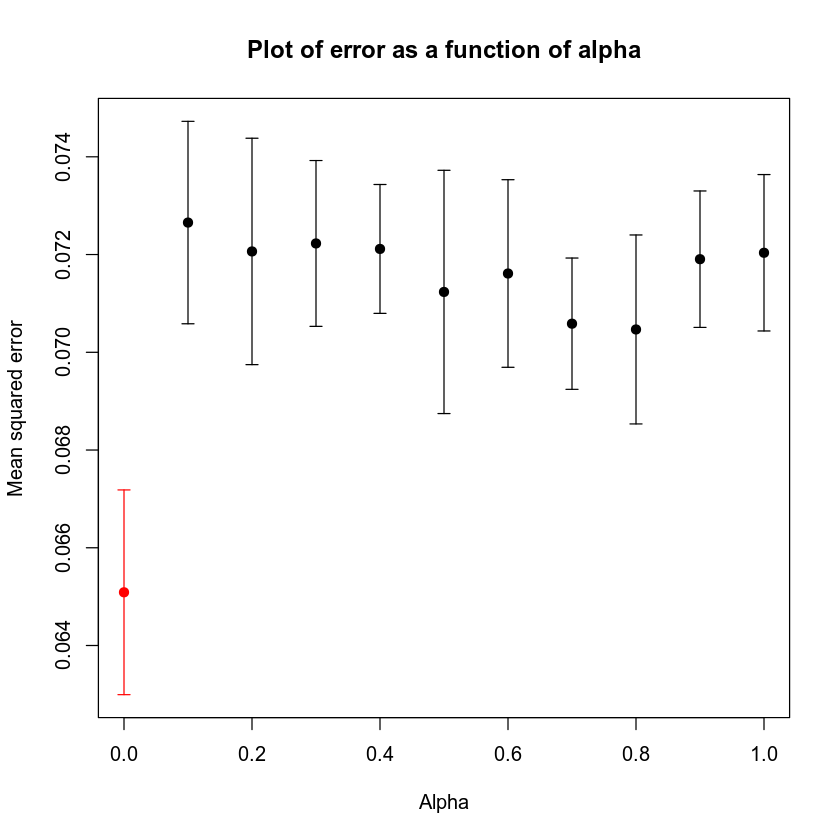

In [57]:
best_alpha <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$alpha
best_lambda <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$lambda.min
plot(elasticnet_df$alpha, elasticnet_df$cvm,
     ylim=range(c(elasticnet_df$cvm-elasticnet_df$cvsd, elasticnet_df$cvm+elasticnet_df$cvsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black")
    )
arrows(elasticnet_df$alpha, elasticnet_df$cvm-elasticnet_df$cvsd, 
       elasticnet_df$alpha, elasticnet_df$cvm+elasticnet_df$cvsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black"))

In [59]:
cat(sprintf('Elastic net: best alpha = %f, best lambda = %f', best_alpha, best_lambda))

Elastic net: best alpha = 0.000000, best lambda = 9.393661

In [ ]:
alphalist <- seq(0.1,1,by=0.1)
overlap_gl <- lapply(alphalist, function(a){
    cat(sprintf("Started alpha:\t%f, at time %s\n", a, Sys.time()), file="overlap_output.txt", append=TRUE)
    grp_fit_temp <- cv.grpregOverlap(x, y, path_group_df, penalty="grLasso", alpha=a)
    cat(sprintf("Ended alpha:\t%f, at time %s\n", a, Sys.time()), file="overlap_output.txt", append=TRUE)
    grp_fit_temp
})

In [ ]:
overlap_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                            o$lambda[o$cve == min(o$cve)]}))), 
                            'cve' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                                min(o$cve)}))),
                            'cvse' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                                o$cvse[o$cve == min(o$cve)]}))),
                            'alpha' = alphalist)

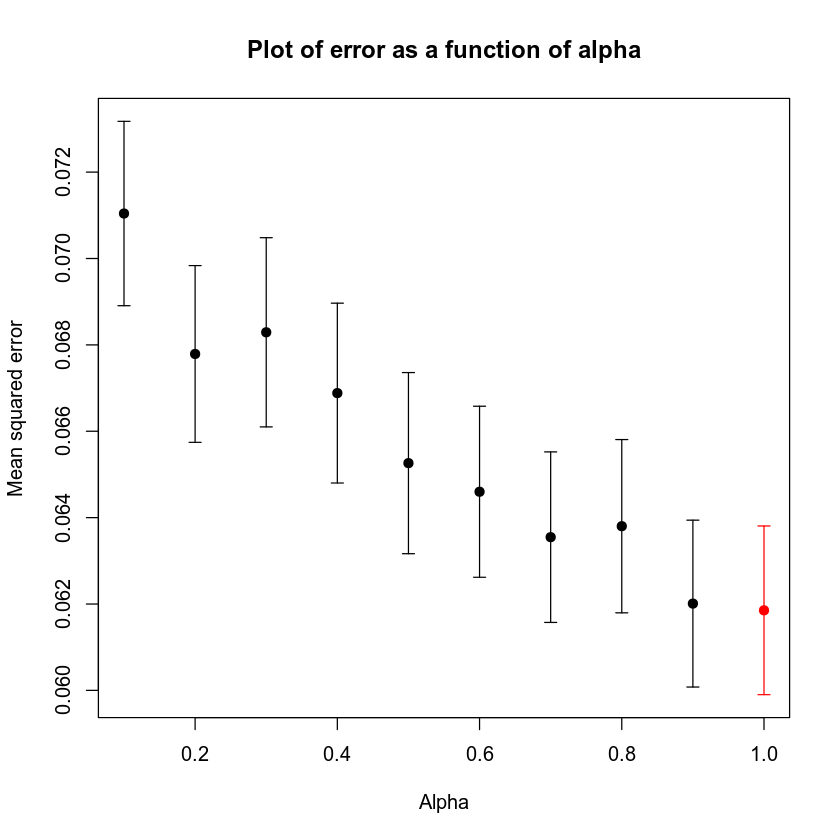

In [55]:
best_alpha_ovl <- overlap_gl_df[overlap_gl_df$cve == min(overlap_gl_df$cve),]$alpha
best_lambda_ovl <- overlap_gl_df[overlap_gl_df$cve == min(overlap_gl_df$cve),]$lambda.min
plot(overlap_gl_df$alpha, overlap_gl_df$cve,
     ylim=range(c(overlap_gl_df$cve-overlap_gl_df$cvse, overlap_gl_df$cve+overlap_gl_df$cvse)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(overlap_gl_df$alpha==best_alpha_ovl, "red", "black")
    )
arrows(overlap_gl_df$alpha, overlap_gl_df$cve-overlap_gl_df$cvse, 
       overlap_gl_df$alpha, overlap_gl_df$cve+overlap_gl_df$cvse, 
       length=0.05, angle=90, code=3,
       col=ifelse(overlap_gl_df$alpha==best_alpha_ovl, "red", "black"))

In [ ]:
print('hello')

In [54]:
cat(sprintf('Overlapping Group Lasso: best alpha = %f, best lambda = %f', best_alpha_ovl, best_lambda_ovl))

Overlapping Group Lasso: best alpha = 1.000000, best lambda = 0.012099

In [145]:
save(elasticnet_df, overlap_gl_df, file='DataFrames/RealDataRegTuneDF.RData')

In [154]:
save(elasticnet, file='/projects/leelab3/psturm/tuneElasticFull.RData')

In [155]:
save(overlap_gl, file='/projects/leelab3/psturm/tuneOverlapFull.Rdata')

In [1]:
load('/projects/leelab3/psturm/tuneElasticFull.RData')

In [2]:
load('/projects/leelab3/psturm/tuneOverlapFull.Rdata')

In [18]:
length(elasticnet)

[1] 11

In [24]:
library(repr)
options(repr.plot.width=5, repr.plot.height=3)

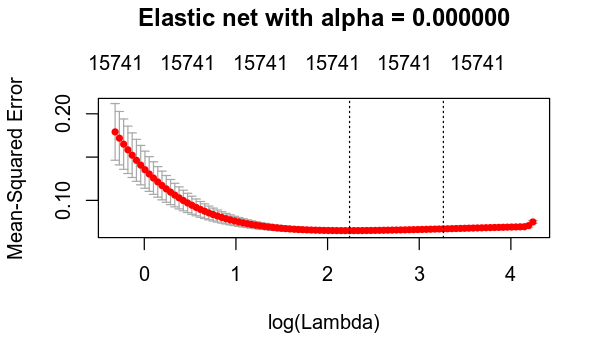

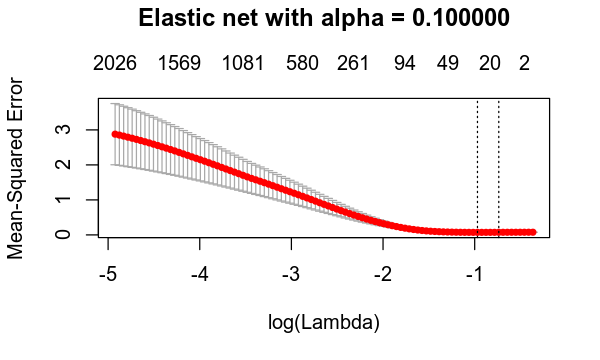

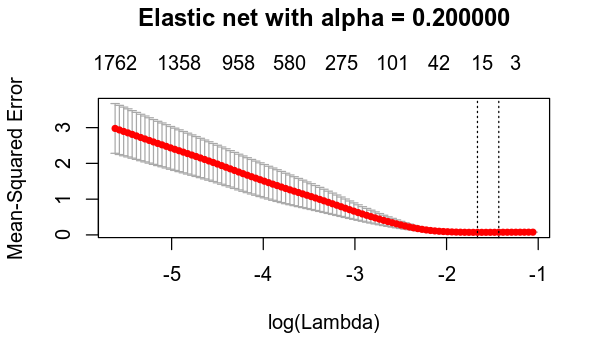

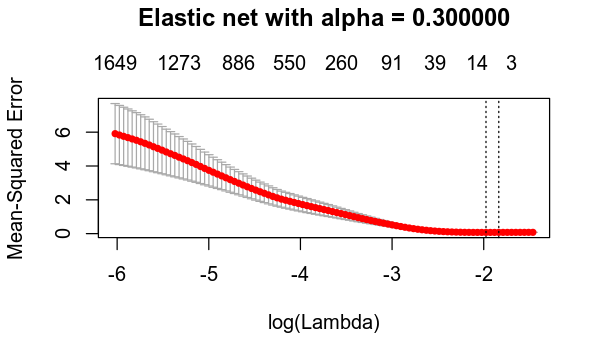

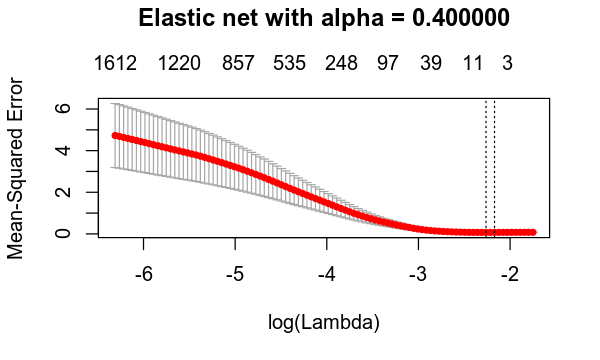

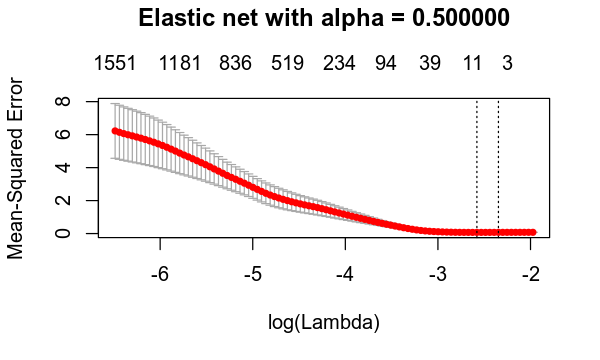

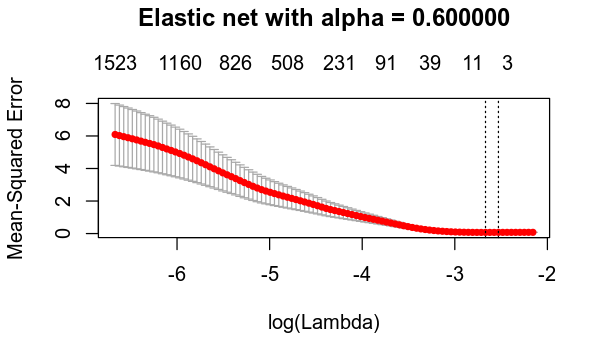

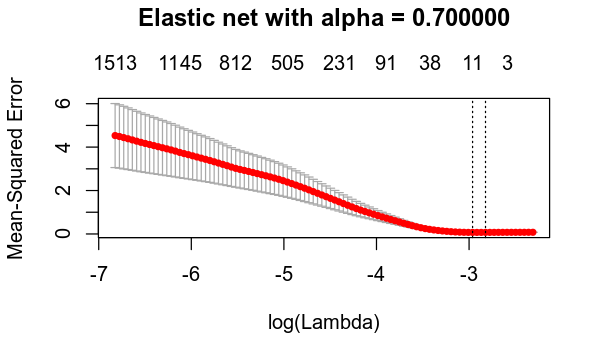

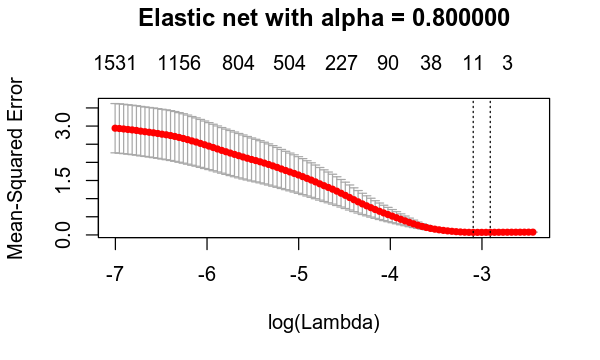

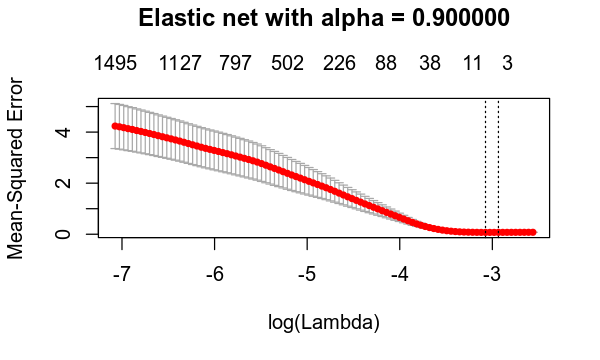

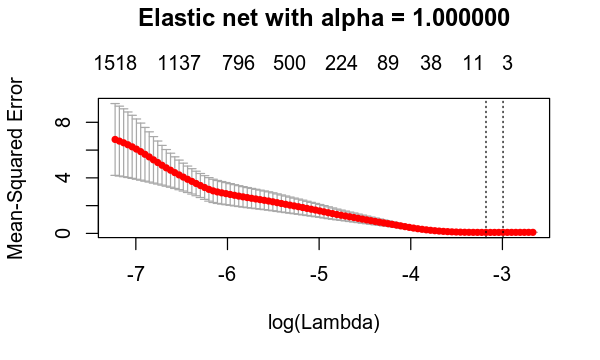

In [25]:
alphalist <- seq(0,1,by=0.1)
for (i in 1:11) {
    plot(elasticnet[[i]])
    title(sprintf('Elastic net with alpha = %f', alphalist[[i]]), line=3)
}

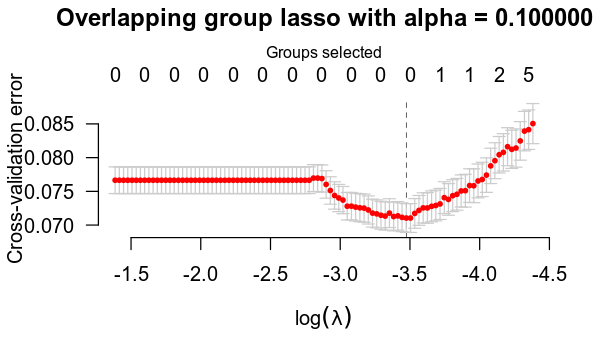

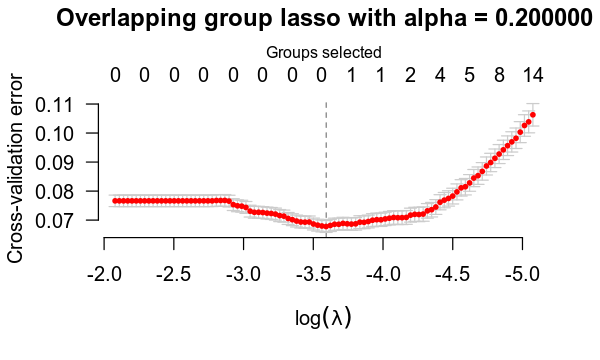

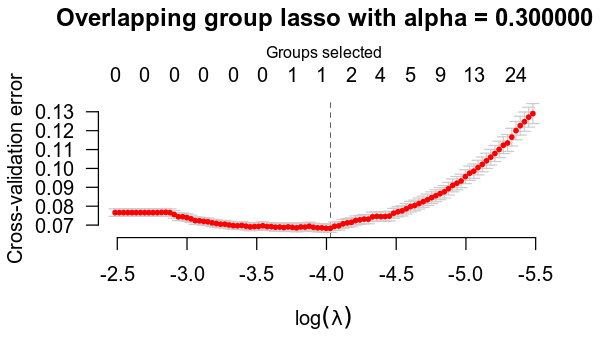

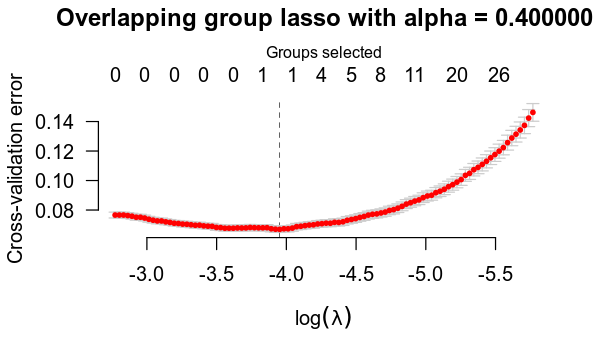

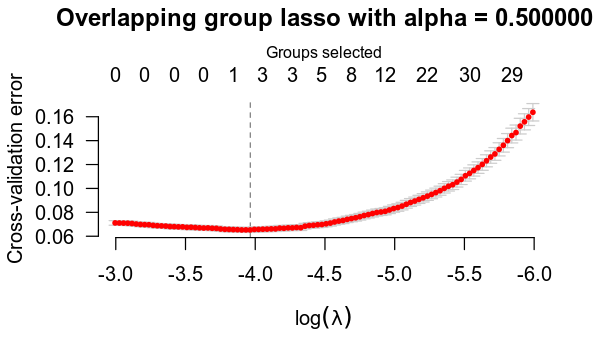

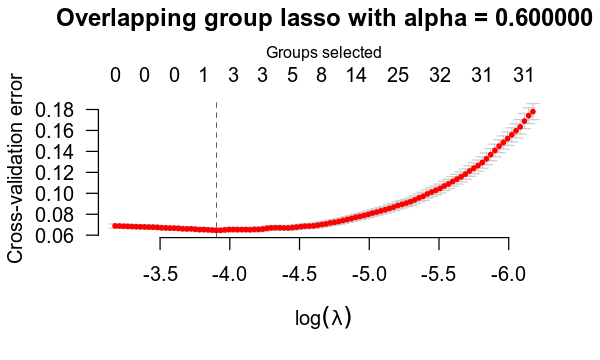

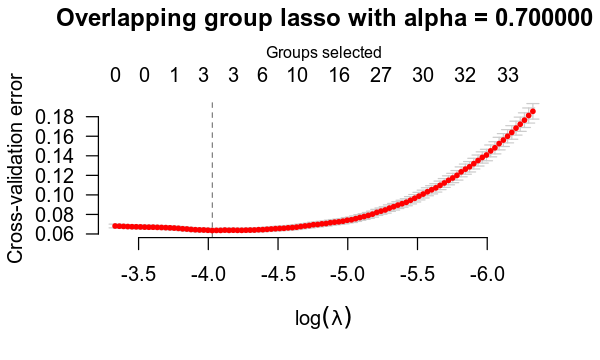

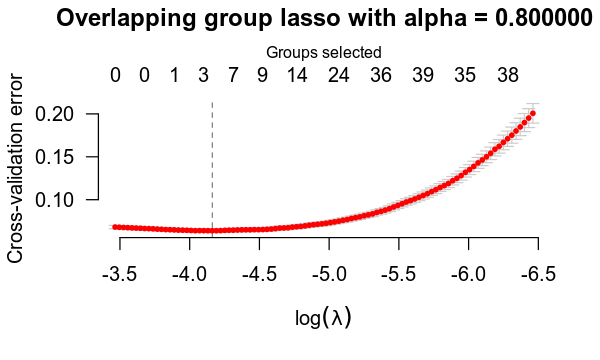

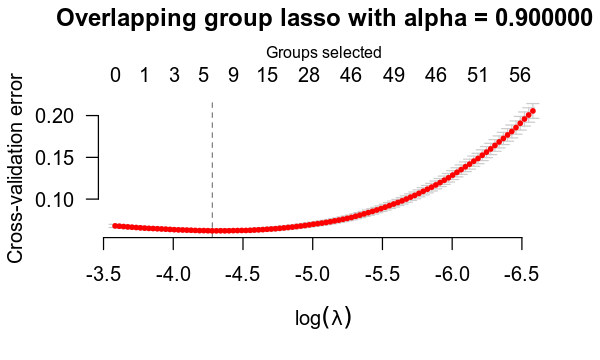

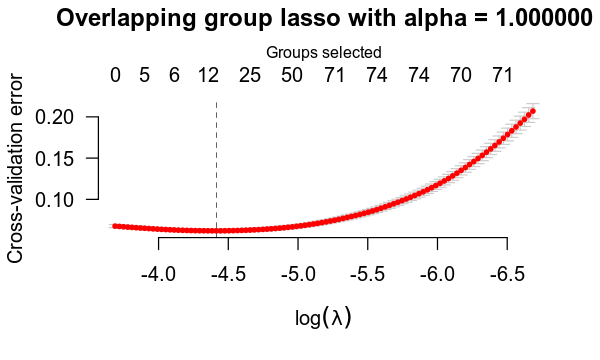

In [26]:
alphalist <- seq(0.1,1,by=0.1)
par(mfrow=c(1, 1))
for (i in 1:10) {
    plot(overlap_gl[[i]])
    title(sprintf('Overlapping group lasso with alpha = %f', alphalist[[i]]), line=3)
}